## Baseline Estimation

This script demonstrates how to load in the developed models, load in the required meteorology and use them to predict baseline data points.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

import sys
sys.path.append('../../')
import config as cfg
import functions as f

site, site_name, compound, model_type = f.access_info()

print(f"Estimating baselines for \033[1m{compound}\033[0;0m at \033[1m{site_name}\033[0;0m.")

Estimating baselines for ch4 at Mace Head, Ireland.


##### Loading in Data

In [2]:
# extracting NAME/InTEM baseline flags for given site
df_flags = f.read_intem(site)

# converting to xarray dataset
ds_flags = df_flags.to_xarray()

In [3]:
# loading in meteorological data for given site
# loading in meteorological data for given site
# 10m wind
ds_10m_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'10m_wind_grid').glob('*u*.nc'))
ds_10m_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'10m_wind_grid').glob('*v*.nc'))

# 850hPa wind
ds_850hPa_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'850hPa_wind_grid').glob('*u*.nc'))
ds_850hPa_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'850hPa_wind_grid').glob('*v*.nc'))

# 500hPa wind
ds_500hPa_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'500hPa_wind_grid').glob('*u*.nc'))
ds_500hPa_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'500hPa_wind_grid').glob('*v*.nc'))

# surface pressure
ds_sp = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'surface_pressure').glob('*.nc'))

# boundary layer height
ds_blh = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'boundary_layer_height').glob('*.nc'))

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# grabbing AGAGE mole fraction data
if compound == 'ch4':
    # choosing the combined dataset
    datasets = list((data_path / "AGAGE" / "AGAGE-public-files" / compound).glob(f"*{site}_{compound}*.nc"))
    if len(datasets) > 1:
        for data in datasets:
            if 'combined' in str(data):
                ds_agage = xr.open_dataset(data)
    else:
        ds_agage = xr.open_dataset(datasets[0])
else:
    ds_agage = xr.open_dataset(next((data_path / "AGAGE" / "AGAGE-public-files" / compound).glob(f"*{site}_{compound}.nc")))                 

In [5]:
# creating an xarray dataset with all the meteorological data, the AGAGE data, and the baseline flags, based on the flags time index
# adding a tolerance to the reindexing to allow for the AGAGE data to be reindexed to the nearest hour to avoid extrapolation of missing data
data_ds = xr.merge([ds_flags,
                    ds_10m_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_10m_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_850hPa_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_850hPa_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_500hPa_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_500hPa_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_sp.reindex(time=ds_flags.time, method='nearest'),
                    ds_blh.reindex(time=ds_flags.time, method='nearest'),
                    ds_agage.mf.reindex(time=ds_flags.time, method='nearest', tolerance=np.timedelta64(1, 'h'))],
                    compat='override',
                    combine_attrs='drop')

data_ds = data_ds.drop_vars('level')

# dropping any years after the final agage year
agage_years = np.unique(ds_agage['time.year'])
data_ds = data_ds.sel(time=data_ds['time.year'] <= agage_years[-1])

In [6]:
# balancing the dataset
minority_ratio = 0.6 # this can be changed, but needs to match the minority ratio in the training data
balanced_data_ds = f.balance_baselines(data_ds, minority_ratio)

In [7]:
data_df = pd.DataFrame({"flag": balanced_data_ds.baseline.values}, index=balanced_data_ds.time.values)

points = balanced_data_ds.points.values

u10_columns = [f"u10_{point}" for point in points]
v10_columns = [f"v10_{point}" for point in points]
u850_columns = [f"u850_{point}" for point in points]
v850_columns = [f"v850_{point}" for point in points]
u500_columns = [f"u500_{point}" for point in points]
v500_columns = [f"v500_{point}" for point in points]

# concatenating the dataframe with the meteorological & temporal data
data_df = pd.concat([
    data_df,
    pd.DataFrame(balanced_data_ds.u10.sel(points=points).values, columns=u10_columns, index=data_df.index),
    pd.DataFrame(balanced_data_ds.v10.sel(points=points).values, columns=v10_columns, index=data_df.index),
    pd.DataFrame(balanced_data_ds.u850.sel(points=points).values, columns=u850_columns, index=data_df.index),
    pd.DataFrame(balanced_data_ds.v850.sel(points=points).values, columns=v850_columns, index=data_df.index),
    pd.DataFrame(balanced_data_ds.u500.sel(points=points).values, columns=u500_columns, index=data_df.index),
    pd.DataFrame(balanced_data_ds.v500.sel(points=points).values, columns=v500_columns, index=data_df.index),
    pd.DataFrame({"sp": balanced_data_ds.sp.values}, index=data_df.index),
    pd.DataFrame({"blh": balanced_data_ds.blh.values}, index=data_df.index),
    pd.DataFrame({"time_of_day": data_df.index.hour}, index=data_df.index),
    pd.DataFrame({"day_of_year": data_df.index.dayofyear}, index=data_df.index)],
    axis=1)

In [8]:
# dimensionality reduction, if model type is random forest
if cfg.model_type == 'rf':
    num_components = 20 # this can be changed, but needs to match the desired variance in the training data
    data_df, pca_loadings = f.reduce_dimensions(data_df, num_components)

Explained variance with 20 components: 86.6%


In [9]:
data_df.sample(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
2023-02-17 23:00:00,1.239040,-0.775997,-3.913887,1.498291,2.365386,-2.346786,4.368919,-2.148100,2.067679,0.615574,...,-0.076930,0.388840,-0.125692,0.527446,2.068773,1.411879,-0.784881,-1.937823,0.512059,1.0
2005-09-07 19:00:00,2.109300,-0.496341,-1.581634,-1.022643,2.512274,-0.991470,1.115722,-4.178311,0.382914,1.637901,...,0.670526,-0.830612,-0.925511,0.688624,2.049955,-1.068167,-0.293584,-0.304396,0.099536,0.0
1993-03-19 03:00:00,-3.282286,2.779737,-6.790744,0.008777,1.682277,-1.313772,2.590440,3.428764,-0.902400,0.110214,...,1.143894,0.343099,-0.532761,-1.505019,-0.884812,-0.201994,0.148962,0.944387,-2.327474,1.0
1994-07-21 15:00:00,1.425175,1.416462,-0.581076,-3.557186,-1.264532,-3.795355,-1.559298,-0.159298,0.634357,0.301436,...,-1.274702,0.139660,-1.263422,-0.291184,-0.183186,-0.127098,0.632350,0.148473,0.404418,1.0
2012-12-23 03:00:00,8.817832,-4.817210,2.114229,2.429469,1.279232,-3.297864,-1.675207,2.364740,1.737646,-1.849396,...,2.175651,-0.589004,1.346947,1.042135,-1.000100,0.011553,0.562475,1.164283,0.304390,0.0


##### Making Predictions

In [10]:
# loading in the chosen model
model_name = f'{model_type}_model_{site}.joblib'
model_path = Path('models')/'model_files'/model_name
model = load(model_path)

print(f"Loaded {model_name}.")

Loaded rf_model_MHD.joblib.


In [11]:
results = f.make_predictions(model)

Predictions made using random forest model.


In [12]:
f.quantify_noise(results)
f.calc_statistics(results)

Overall Coefficient of Variation of True Baseline Values for ch4: 0.005
Number of predicted baseline values: 23424, Number of predicted non-baseline values: 23359
True Mean: 1868.792, Model Mean: 1868.700
True Std Dev: 54.410, Model Std Dev: 55.998
Mean Absolute Error: 3.234
Root Mean Squared Error: 6.748
Mean Absolute Percentage Error: 0.175


##### Plotting Results

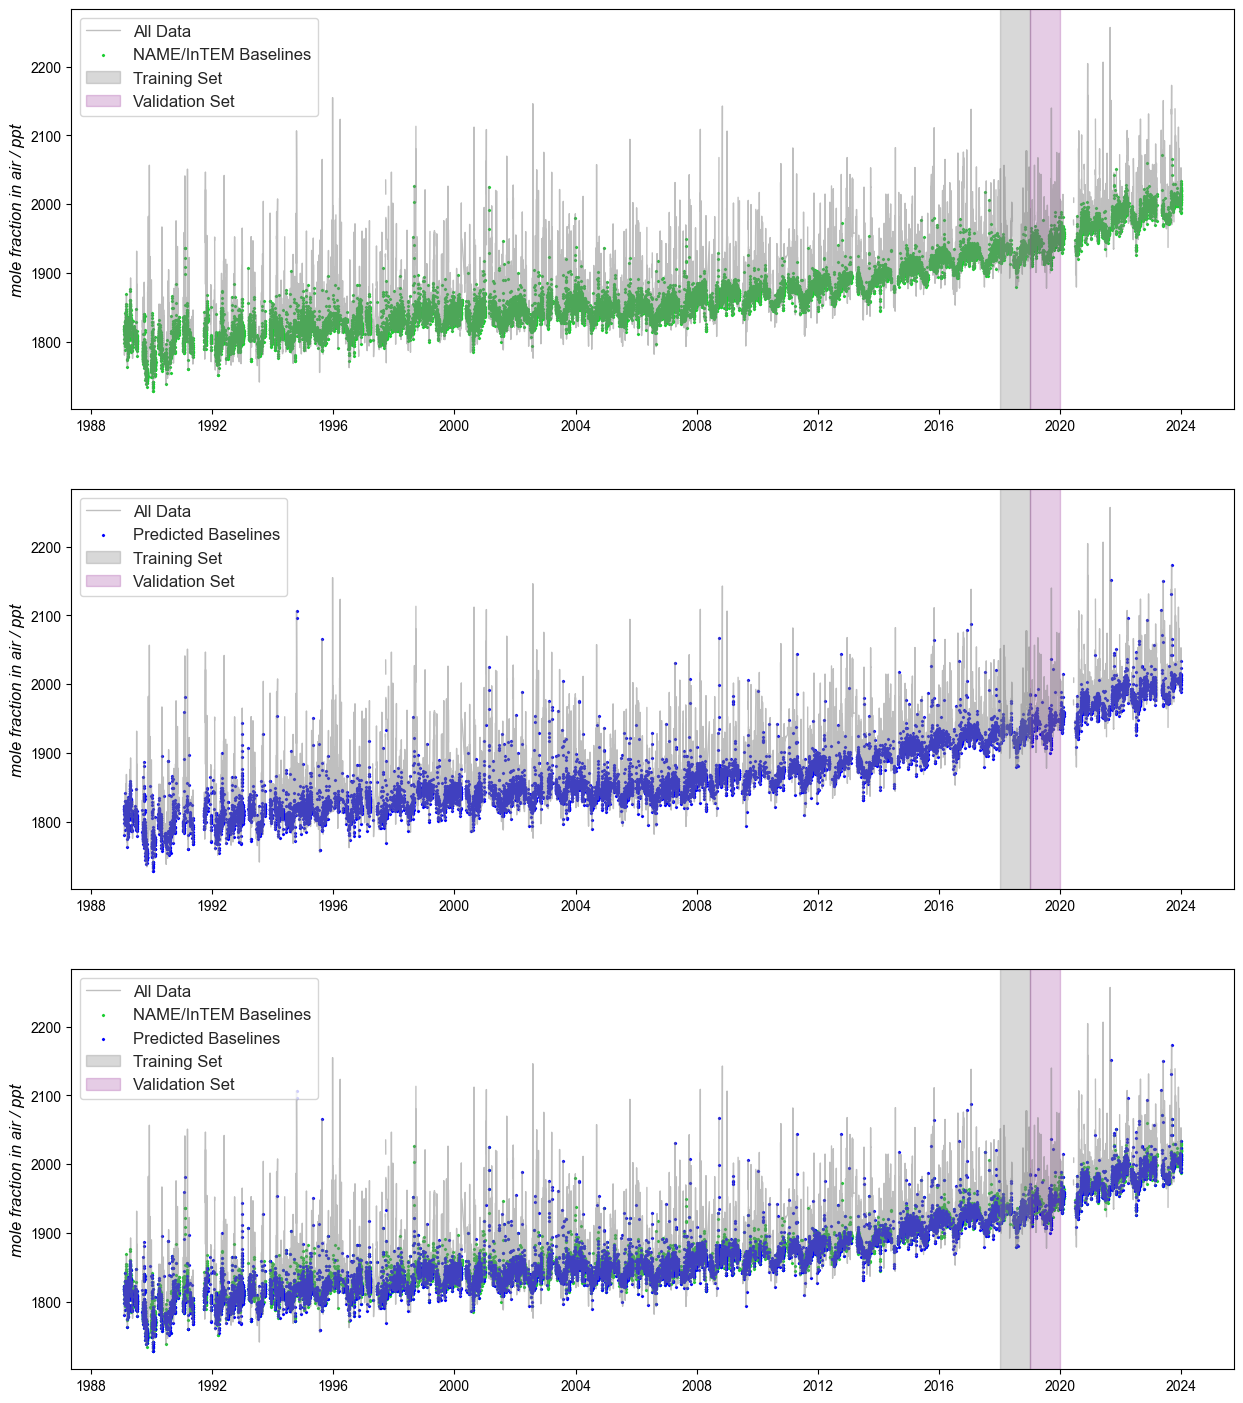

In [13]:
f.plot_predictions(results)

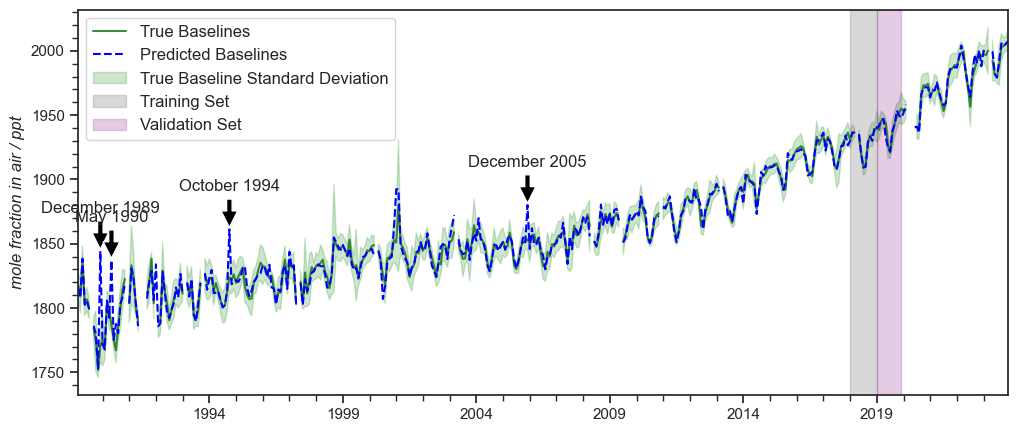

Number of anomalies (>3σ): 4
Anomalous month(s): ['1989-12', '1990-05', '1994-10', '2005-12']
Number of anomalies within 5σ: 2/4 (50.0%)
Number of anomalies within 10σ: 3/4 (75.0%)
Significant anomalies (>10σ): ['1990-05']
Percentage of non-anomalous months: 99.0%


In [14]:
f.plot_predictions_monthly(results)

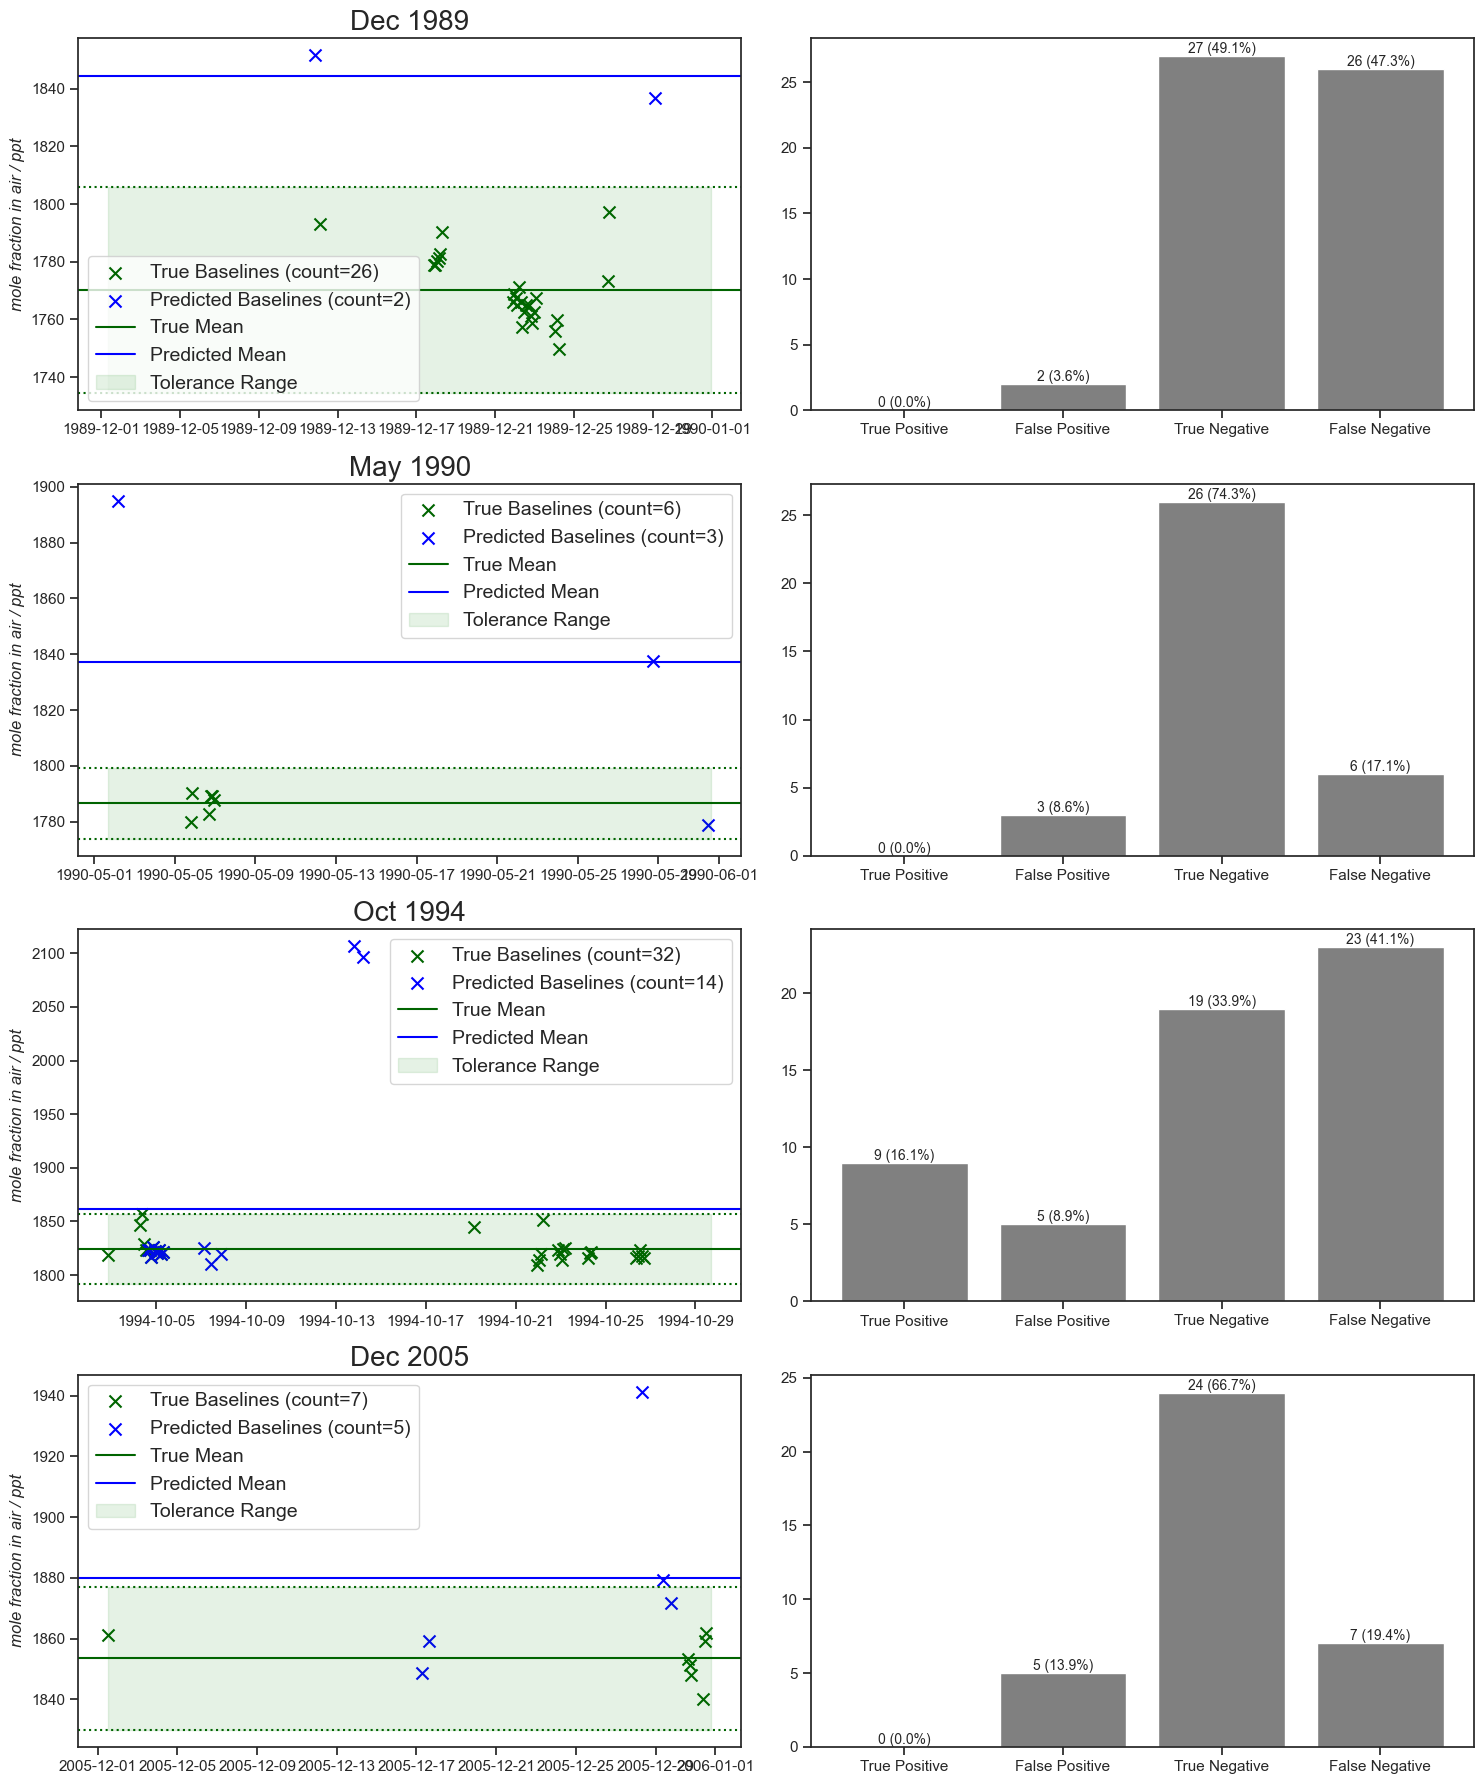

In [15]:
anomalies_list = ['1989-12', '1990-05', '1994-10', '2005-12']
f.analyse_anomalies(results, anomalies_list)

##### Residual Analysis

Residuals saved to rf_residuals_ch4_MHD.csv


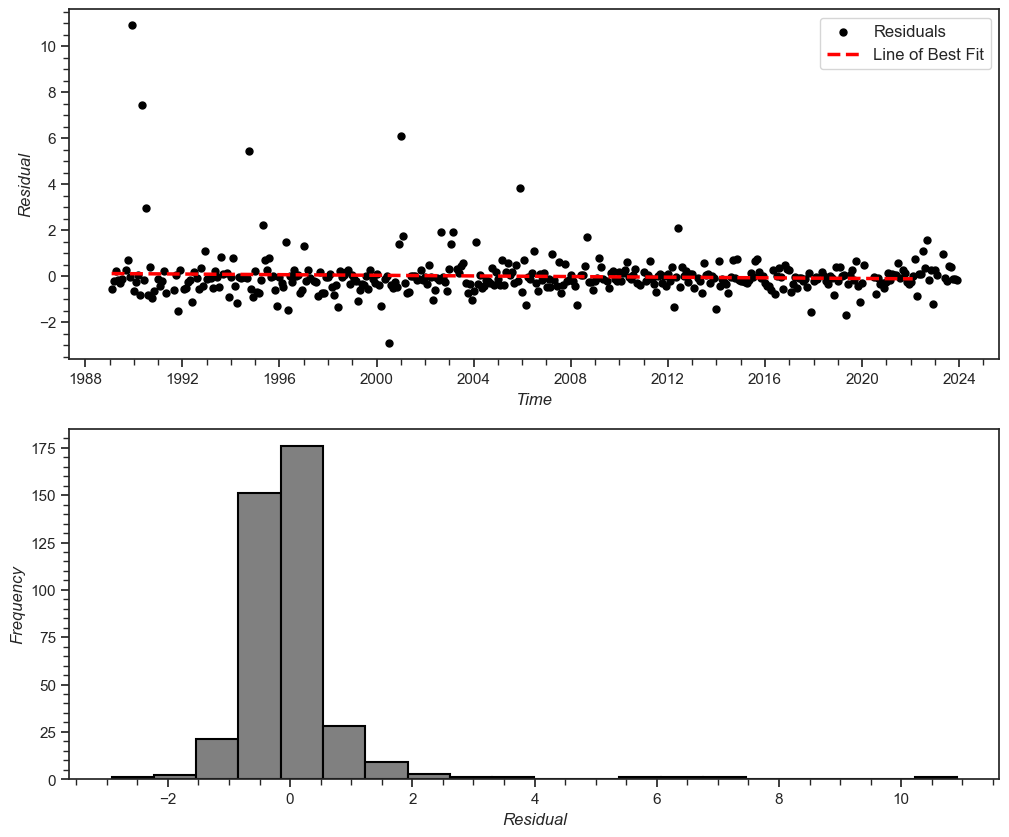

In [18]:
residuals = f.calc_residuals(results)
f.plot_residuals(residuals)

1 compound residual file found.
Percentage of residuals within 1 standard deviation: 89.9%
Percentage of residuals within 3 standard deviations: 98.7%


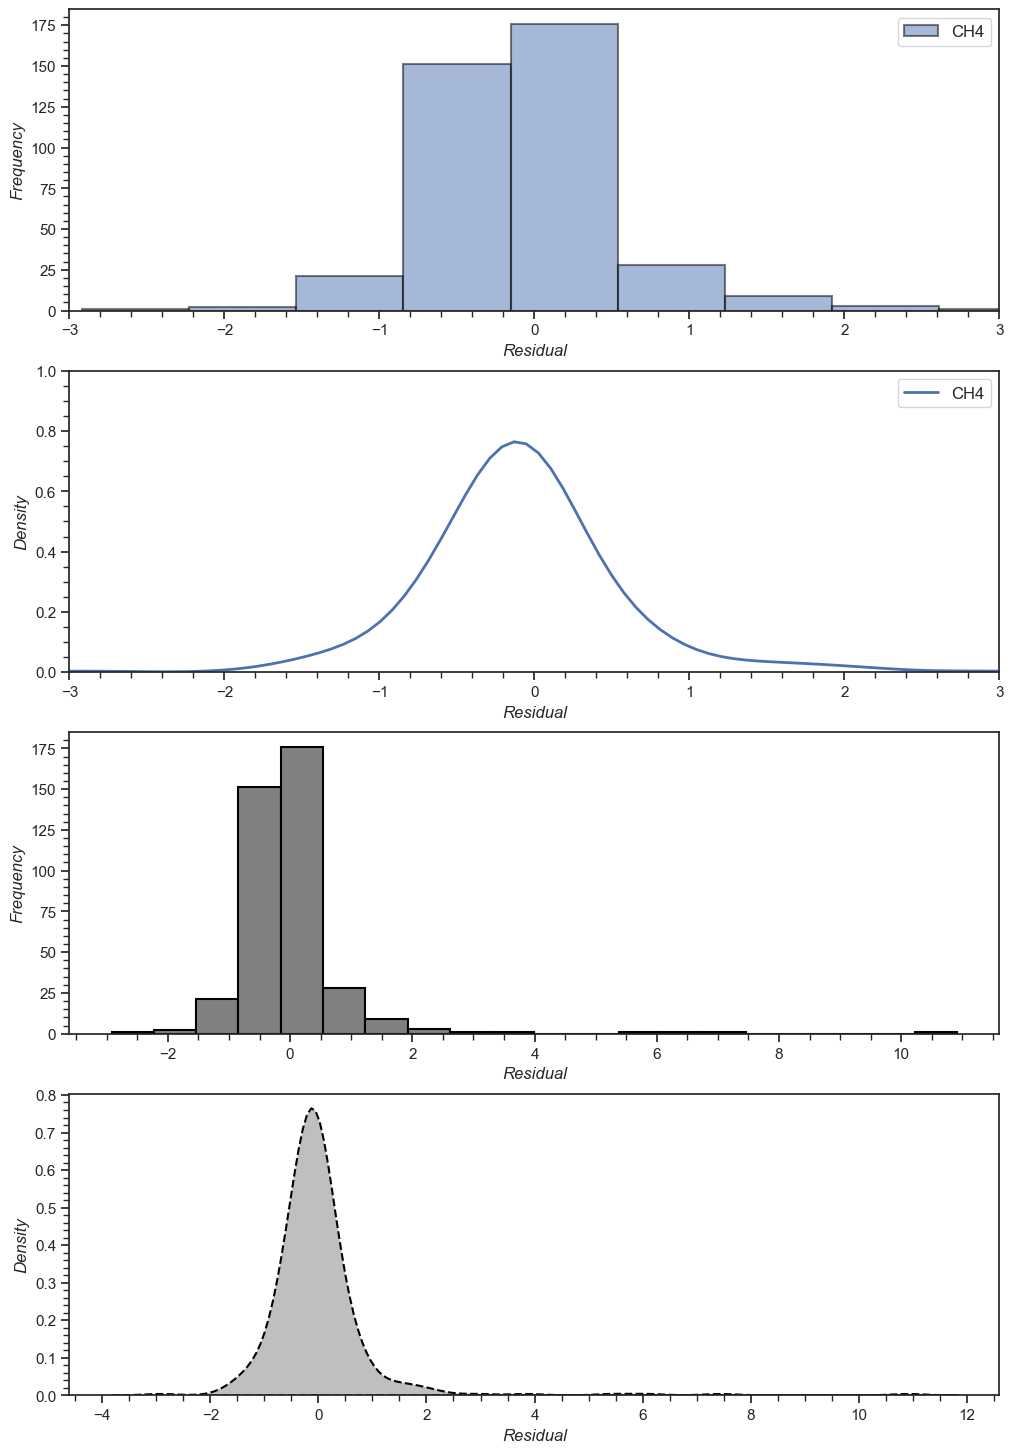

In [17]:
f.aggregate_residuals()